# Preliminaries
First of all, prerequired modules and packages are imported 
and the default options for plot are set.

## Install

In [0]:
###!pip install numpy scipy pandas matplotlib scikit-learn tensorflow keras
#pip install qutip

## Imports

In [4]:
%time
import time
##################
from __future__ import absolute_import, division, print_function
#####
import warnings
import pickle
import io, requests, zipfile
from contextlib import redirect_stdout
import sys

#####
import multiprocessing as mp # Pool , cpu_count
import numpy as np
import pandas as pd
import sympy as sym
import matplotlib.pyplot as plt
import seaborn
import tensorflow as tf
import sklearn as sk
#import qutip as Q
#from numba import jit, prange
#####
from scipy.optimize import minimize
from scipy.stats import expon
#####
from sklearn.utils import shuffle
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder , label_binarize
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler # scale
#####
from sklearn.feature_selection import RFE, RFECV, SelectFromModel
from sklearn.decomposition import PCA 
from sklearn.manifold import MDS, LocallyLinearEmbedding, Isomap, SpectralEmbedding, TSNE
#####
from sklearn.model_selection import train_test_split ,  cross_val_score , cross_validate, learning_curve## only one split, cv split only scores, cv split scores and more info, cross_validate on different train_sizes
from sklearn.model_selection import GridSearchCV , RandomizedSearchCV , validation_curve # on params
#####
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import RidgeClassifier, SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
#####
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import Ridge, Lasso, LinearRegression, LogisticRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
#####
from sklearn.ensemble import BaggingClassifier, ExtraTreesClassifier, RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.ensemble import RandomForestRegressor
#from xgboost import XGBClassifier
#from mlxtend.classifier import StackingClassifier
#####
from sklearn.metrics import make_scorer
from sklearn.metrics import mean_squared_error, f1_score, accuracy_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix,  classification_report #cnfmatrix = confusion_matrix(Y,predicted_Y)
from sklearn.metrics import precision_recall_curve , roc_curve , roc_auc_score

CPU times: user 2 µs, sys: 1 µs, total: 3 µs
Wall time: 5.25 µs


## Setting some Options

In [0]:
'''Set the defaults for your plots.'''
# plt.rcParams.update({'font.size': 20, 'figsize':(8,6)})
SMALL_SIZE = 12
MEDIUM_SIZE = 15
BIGGER_SIZE = 18

plt.rc('font', size=BIGGER_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
plt.rc('axes', linewidth = 3 )
plt.rc('lines', linewidth = 3 )
plt.rc('lines', markersize = 5 )
plt.rc('figure', figsize=(20,8) )         # Image size

#####
warnings.filterwarnings('always')
#warnings.filterwarnings('ignore')
#####
np.random.seed(7) # fix random seed for reproducibility
#####
org_stdout=sys.stdout

# Functions and Classes
The following user-defined functions and classes are written to make the main code more readable and compact.

## Data Collection / Generation

The method used for data generation is to use qutip module and generate a Random Density Matrice and then Calculate the 
Measurements on the Generated Density Matrice 


by calculating the determinant of the parital transposed density matrix, it can be de decided whether the state is entangled or not.

The matrix of features is in the form:

 $$Features = \begin{bmatrix}
\sigma_x\otimes\sigma_x & \sigma_x\otimes\sigma_y & \sigma_x\otimes\sigma_z & \sigma_x\otimes\ \mathbb{1} 
\\ \sigma_y\otimes\sigma_x & \sigma_y\otimes\sigma_y & \sigma_y\otimes\sigma_z & \sigma_y\otimes\ \mathbb{1}
\\ \sigma_z\otimes\sigma_x & \sigma_z\otimes\sigma_y & \sigma_z\otimes\sigma_z & \sigma_z\otimes\ \mathbb{1}
\\ \mathbb{1}\otimes\sigma_x & \mathbb{1}\otimes\sigma_y & \mathbb{1}\otimes\sigma_z & \mathbb{1}\otimes\ \mathbb{1}
\end{bmatrix}$$

The features are then reformed to (15 , 1) shape where $$ \mathbb{1} \otimes \mathbb{1} $$ feature is ommited since it's always 1.


The following function 'data_gen' recieves 'N' of type int, the number of samples to generate, and 'verbose' of type int, the vorbosity to report during generation.

return type is a DataFrame contains N records of random density matrices and contains following fields:

-15 features for the density matrix

-the PPT criterion, which is the determinant of the partial transpose of the bi-partite system. The PPT criterion says that if this value is negative, then the density matrix is entangled and if positive, then it is seprable

-the binary class of these matrices, where label '1' is for entangled matrices and '0' denotes the class of seprable matrices.


the following functions, "my_data_gen" is used to generate the data and return a pandas dataframe

In [0]:
def my_gen(N):
  a=time.time()
  seed=int((a*10 - int(a*10))*1_000_000_000)
  np.random.seed(seed)
  sigma=[ Q.sigmax(), Q.sigmay(), Q.sigmaz(), Q.identity(2)]
  X = np.empty((N,15))
  y = np.empty(N)
  yc = np.empty(N,dtype=np.int64)

  for k in range(N):
    rho1 = Q.rand_dm(4,dims=[ [2,2] , [2,2] ] )
    f = [ (rho1* Q.tensor(A,B)).tr().real for A in sigma for B in sigma ]
    del f[-1]
    X[k] = f
    rho2 = Q.partial_transpose(rho1, [0,1] )
    y[k] = np.linalg.det(rho2.full()).real
  yc = pd.DataFrame(y<0,columns=['is_entangled'])
  y=pd.DataFrame(y,columns=['entanglement'])
  sigma = ['sigma_x','sigma_y','sigma_z','I']
  columns = ['{} {}'.format(A,B) for A in sigma for B in sigma]
  del columns[-1]
  X = pd.DataFrame(X,columns=columns)
  return pd.concat([X,y,yc],axis=1)

def my_data_gen(N, n_jobs=-1):
  '''
  N : int : number of samples : O(N)
  n_jobs : int : number of processors for parallel computing, -1  for max possible

  --- return ---
  data : pd.DataFrame : data
  '''

  t=time.time()
  if n_jobs == -1: n_jobs = mp.cpu_count()
  print('running with n_jobs : {}'.format(n_jobs))
  f=n_jobs*100
  N_list = [N//f]*f + [N%f]

  data_list=[]
  with mp.Pool(processes=n_jobs) as pool:
      for i,data in enumerate(pool.imap_unordered(my_gen,N_list) , 1):
          elapsed_time = int(time.time()-t)
          sys.stderr.write('\rdone {:.2%} , time : {} min , {} s , estimated total time : {} min , {} s '.format( i/len(N_list) , elapsed_time//60 , elapsed_time%60 , int(len(N_list)/i * elapsed_time)//60 , int(len(N_list)/i * elapsed_time)%60 ))
          data_list += [data]

  data=pd.concat(data_list)
  return data

## Learning

In [0]:
def my_GridSearchCV(estimator,x_train,y_train,cv=5,refit='accuracy',pos_label=0):
  if is_clf(estim) :
    scoring = {'AUC': 'roc_auc', 'accuracy': make_scorer(accuracy_score), 'precision':make_scorer(precision_score, pos_label=pos_label)
           , 'recall':make_scorer(recall_score, pos_label=pos_label), 'f1':make_scorer(f1_score, pos_label=pos_label)}
  else :
    scoring = None
    refit = True

  opt_estimator = RandomizedSearchCV(estimator, param_distributions=params_dist[estim], cv=cv, n_jobs=-1,
                                     refit=refit, scoring= scoring,verbose=10)
  #opt_estimator =GridSearchCV(estimator, param_grid=params_dist[estim], cv=cv, n_jobs=-1,
  #                            refit=refit, scoring= scoring, verbose=10)
  opt_estimator.fit( x_train, y_train )

  print("#######################")
  print("Best Score : {} ".format(opt_estimator.best_score_))
  print("Best params : \n  {}".format(opt_estimator.best_params_))
  print("#######################")
  return opt_estimator.best_params_ , opt_estimator.best_estimator_

## Model Analyzing

### Score Analyzing

In [0]:
def my_clf_score_analyze(clf,X_test,y_test):
  print('##################################################################')
  print('Test Score on test set : {}'.format(clf.score(X_test,y_test)))
  print('----------------------------')
  y_predicted = clf.predict(X_test)
  print('Confusion Matirix : \n')
  print(confusion_matrix(y_test,y_predicted))
  print('----------------------------')
  print(classification_report(y_test,y_predicted))
  print('----------------------------')
  print('AUC : {}'.format(roc_auc_score(y_test,y_predicted)))
  print('----------------------------')
  return

In [0]:
def my_precision_recall_curve(estimator,X_test,y_test):
  try:
    decision_values = estimator.predict_proba(X_test)
  except:
    decision_values = estimator.decision_function(X_test)
    decision_values = np.concatenate( ((1-decision_values).reshape(-1,1) ,decision_values.reshape(-1,1) ) , axis=1)

  fig, ax = plt.subplots(1, 2, constrained_layout=True,figsize=(12,8))
  fig.suptitle('Precision-Recall Curve for {}'.format(str(estimator)))

  for pos_label in (0,1):
    precision, recall, thresholds = precision_recall_curve(y_test, decision_values[:,pos_label] ,pos_label=pos_label)
    ax[pos_label].plot(recall, precision)
    ax[pos_label].set_title('for class : {}'.format(pos_label))
    ax[pos_label].set_xlabel('Recall')
    ax[pos_label].set_ylabel('Precision')

  plt.show()
  return precision, recall, thresholds

In [10]:
'''
def my_roc_curve(estimator,X_test,y_test) ##or mix with above , cuz it's also optimal
  ### roc curve


  fpr, tpr, thrsld_list = roc_curve(y_test, decision_values[:,0])

  plt_title = 'ROC Curve {}'.format(str(estimator))
  x_label = 'False Positive Rate'
  y_label = 'True Positive Rate'

  fig = plt.figure()
  ax = fig.add_subplot(111,xlabel=x_label, ylabel = y_label, title = plt_title)
  plt.plot(fpr, tpr)
  plt.show()
'''

"\ndef my_roc_curve(estimator,X_test,y_test) ##or mix with above , cuz it's also optimal\n  ### roc curve\n\n\n  fpr, tpr, thrsld_list = roc_curve(y_test, decision_values[:,0])\n\n  plt_title = 'ROC Curve {}'.format(str(estimator))\n  x_label = 'False Positive Rate'\n  y_label = 'True Positive Rate'\n\n  fig = plt.figure()\n  ax = fig.add_subplot(111,xlabel=x_label, ylabel = y_label, title = plt_title)\n  plt.plot(fpr, tpr)\n  plt.show()\n"

### Validation Curve

In [0]:
def my_validation_curve(estimator,param_name,param_range,X_train,y_train,cv=5):
  train_scores, valid_scores = validation_curve(estimator, X_train, y_train, param_name=param_name, param_range=param_range , cv=cv,
                                                verbose=10, n_jobs=-1
                                               )

  train_scores_mean = np.mean(train_scores, axis=1)
  train_scores_std = np.std(train_scores, axis=1)
  valid_scores_mean = np.mean(valid_scores, axis=1)
  valid_scores_std = np.std(valid_scores, axis=1)

  xlabel = param_name
  ylabel = 'Score'

  plt_title = 'Validation curve for {}'.format(str(estimator))

  fig = plt.figure()
  ax = fig.add_subplot(111, xlabel=xlabel, ylabel=ylabel, title=plt_title)
  plt.semilogx(param_range, train_scores_mean, label="Training score",
               color="darkorange", lw=2)
  plt.fill_between(param_range, train_scores_mean - train_scores_std,
                   train_scores_mean + train_scores_std, alpha=0.2,
                   color="darkorange", lw=2)
  plt.semilogx(param_range, valid_scores_mean, label="Validation score",
               color="navy", lw=2)
  plt.fill_between(param_range, valid_scores_mean - valid_scores_std,
                   valid_scores_mean + valid_scores_std, alpha=0.2,
                   color="navy", lw=2)
  plt.legend(loc="best")
  plt.show()
  
  return train_scores, valid_scores

### Learning Curve

In [0]:
def my_learning_curve(estimator,X,y,train_sizes,cv,n_jobs=-1,verbose=10):
  train_size, train_scores, validation_scores = learning_curve( estimator = estimator , X = X,
                                                     y = y, train_sizes = train_sizes, cv = 5,
                                                     n_jobs=n_jobs,verbose=verbose)#scoring = 'neg_mean_squared_error'

  train_scores_mean = train_scores.mean(axis = 1) # *-1 if neg_mean_squared_error
  train_scores_std = np.std(train_scores, axis=1)
  validation_scores_mean = validation_scores.mean(axis = 1)
  validation_scores_std  = validation_scores.std(axis = 1)

  xlabel = 'Sample Size'
  ylabel = 'Score' #'L2-loss'
  plt_title = 'Learning curve for {}'.format(str(estimator))

  fig = plt.figure()
  ax = fig.add_subplot(111, xlabel=xlabel, ylabel=ylabel, title=plt_title)
  ax.plot(train_size, train_scores_mean, label = 'Training Score')
  ax.plot(train_size, validation_scores_mean, label = 'Validation Score')

  plt.fill_between(train_size, train_scores_mean - train_scores_std,
                   train_scores_mean + train_scores_std, alpha=0.2,
                   color="darkblue", lw=2)
  plt.fill_between(train_size, validation_scores_mean - validation_scores_std,
                   validation_scores_mean + validation_scores_std, alpha=0.2,
                   color="darkgreen", lw=2)

  ax.legend(loc=0)

  print('######################')
  print('Last Training Score : {}'.format(train_scores_mean[-1]))
  print('Last Validation score : {}'.format(validation_scores_mean[-1]))
  print('######################')
  plt.show()
  return train_size, train_scores, validation_scores

## Classifier from Regressor
This class recieves a regressor, and make a classifier from that.

In [0]:
class my_clf_from_reg(sklearn.base.BaseEstimator):
  
  #coef_ = lin_reg.coef_
  def __init__(self,reg):
    self.reg = reg
  
  def __str__(self):
    return str(self.reg)
  
  def predict(self,X_test):
    Nt = X_test.shape[0]
    pre_y = self.reg.predict(X_test)
    pre_yc = pre_y < 0
    return pre_yc
  
  def score(self,X_test,yc_test):
    Nt = X_test.shape[0]
    pre_yc=self.predict(X_test)
    err = (yc_test^pre_yc)
    return (Nt-err.sum()) /float(Nt)
  
  def fit(self,X_train,y_train):
    self.reg.fit(X_train,y_train)
    print('reg train score : ', str(self.reg.score(X_train,y_train)))
    return self.reg
  
  def decision_function(self,X):
    return -1*self.reg.predict(X)
  
  def wrong_indices(self,xtest,ytest):
    inds =[]
    Nt = xtest.shape[0]
    pre_yc=self.predict(xtest)
    for i in range(Nt):
      if yctest[i] != pre_yc[i]:
        inds.append(i) 
    return inds
  
    return {}

# Main

## Data Collection / Generation
we can generate and save the data in the following code:

In [0]:
#data = my_data_gen(N=40_000,n_jobs=-1)
#data.to_csv('data.zip', index = False)
#print(data.duplicated().sum())

or we can load the data from cloud or storage

In [0]:
url = 'https://www.dropbox.com/s/1h8a0v0w20hk6n6/data.zip?dl=1' ###????????????
data = pd.read_csv(url,compression='zip')

In [0]:
### ctrl + m . #ctrl + F8

## Data Analysis

In [16]:
print(data.info())
print('number of duplicated data : ',data.duplicated().sum())
data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 17 columns):
sigma_x sigma_x    1000000 non-null float64
sigma_x sigma_y    1000000 non-null float64
sigma_x sigma_z    1000000 non-null float64
sigma_x I          1000000 non-null float64
sigma_y sigma_x    1000000 non-null float64
sigma_y sigma_y    1000000 non-null float64
sigma_y sigma_z    1000000 non-null float64
sigma_y I          1000000 non-null float64
sigma_z sigma_x    1000000 non-null float64
sigma_z sigma_y    1000000 non-null float64
sigma_z sigma_z    1000000 non-null float64
sigma_z I          1000000 non-null float64
I sigma_x          1000000 non-null float64
I sigma_y          1000000 non-null float64
I sigma_z          1000000 non-null float64
entanglement       1000000 non-null float64
is_entangled       1000000 non-null bool
dtypes: bool(1), float64(16)
memory usage: 123.0 MB
None
number of duplicated data :  0


,sigma_x sigma_x,sigma_x sigma_y,sigma_x sigma_z,sigma_x I,sigma_y sigma_x,sigma_y sigma_y,sigma_y sigma_z,sigma_y I,sigma_z sigma_x,sigma_z sigma_y,sigma_z sigma_z,sigma_z I,I sigma_x,I sigma_y,I sigma_z,entanglement,is_entangled
0,0.154747,-0.223492,0.123199,0.121509,0.282910,0.393594,-0.271495,-0.171044,0.134079,0.278033,-0.446923,0.384239,-0.050118,0.083394,-0.035373,-0.002091,True
1,-0.097572,-0.168385,0.066831,-0.133822,-0.475841,-0.068549,-0.104058,-0.396428,-0.358598,0.132050,0.415423,0.242611,0.315306,0.060281,0.485134,-0.001032,True
2,0.171280,-0.320316,0.405734,-0.405734,0.026258,0.097517,-0.240104,0.240104,0.090856,-0.251118,0.311582,-0.128642,0.044862,0.113962,-0.645900,0.000060,False
3,0.377161,-0.072889,0.298018,-0.284318,-0.128933,-0.336420,0.225436,-0.170425,-0.154245,0.183819,-0.198514,0.282051,-0.154245,0.183819,-0.568609,-0.000547,True
4,0.147456,-0.318574,-0.030805,-0.030805,0.318574,0.147456,0.067526,0.067526,-0.308205,-0.257485,-0.305155,0.770491,-0.308205,-0.257485,-0.075645,-0.001901,True


In [0]:
N_sample=10_000
data_mini = data.sample(N_sample , random_state=0)

In [18]:
#data_mini.hist(figsize=(24,14),bins=100)
target = 'is_entangled'
data_mini[target]=data_mini[target]*1 ### do sth for bool binary

_=pd.plotting.scatter_matrix(data_mini, c=data_mini[target] , cmap = plt.cm.Accent,
                            figsize=(len(data_mini.columns)*5,len(data_mini.columns)*5), marker='o', s=25, 
                            hist_kwds={'bins':100})

Output hidden; open in https://colab.research.google.com to view.

As it is seen in the feagure, there is not any obvious corrolations between featrues and entaglement.
Moreover, the histograms are almost gaussian shaped and all the features have ALMOST same histogram. However, there is an issue about the rand_dm method in qutip module, which it doesn't generate symmetric random matrices in each x,y and z direction. It could be easily found from the histogram of these 15 features, where distributions in correspondance to z axis are slightly different from ones to x and y axes.

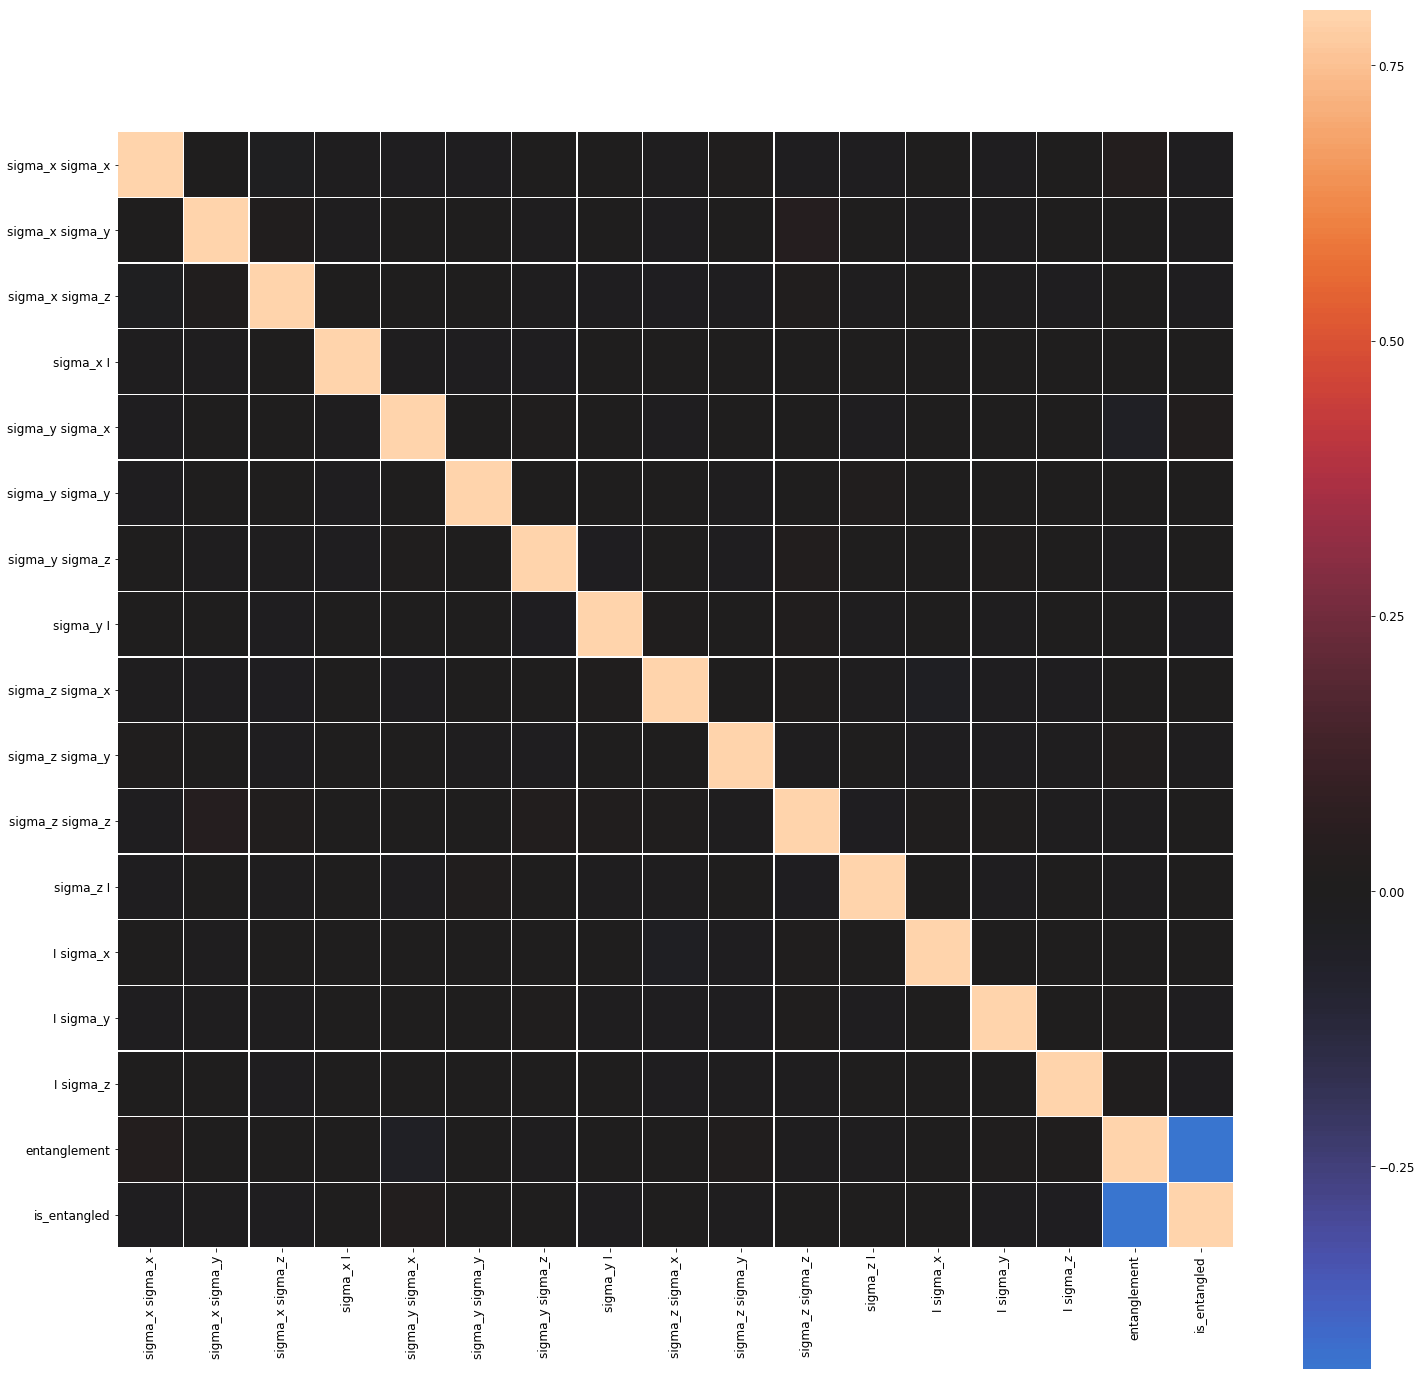

In [24]:

fig = plt.figure(figsize = (25,25))

seaborn.heatmap(data_mini.corr(), vmax = .8, square = True, linewidth=0.3, center=0)
plt.show()

As it is seen in the figure, there is not any linear correlation between features themselves, nor there is any between features and entanglement.

In [44]:
## Frequency of entangled states
print("{} % of the stored data is entangled ".format(100*(data['is_entangled'].sum())/len(data['is_entangled'])))

68.3852 % of the stored data is entangled 


## preprocessing / Data Preperation

In [107]:
%%time
is_clf = True
# is_clf = False
N_sample = 100_000
poly_feature = 0 # 0 or int for degree
scaler = 'StandardScaler' # 'None', 'StandardScaler' , 'RobustScaler' , 'MinMaxScaler'
target_scale = 1000
##################################################################################
features=data.columns.drop(['entanglement','is_entangled'])
if is_clf:
  target='is_entangled'
else:
  target='entanglement'
### missing data
#pd.isna() np.NaN == np.NaN : False
#data_mod = data_mod.dropna()
#df1.fillna() #for id : df1.fillna( df1.mean()['A':'B'] ) columns mean
#df1.fillna(method='pad') # 'backfill'
#df1.interpolate() ##lots of method=''
#df1.replace({0: 10, 1: 100}) #if forexample the misings are not Nan but 0 and 1 

###shuffle
data_mod = shuffle(data,random_state=0)
 
### data sampling
data_mini = data_mod.sample(N_sample , random_state=0)

### X , y
X = data_mini[features]
y = data_mini[target]

### cleanup (numeric labels)
if is_clf:
  label_encoder = LabelEncoder()
  y = label_encoder.fit_transform(y)
  #y = label_binarize(y, classes=[0, 1]) #one vs other?
else:
  y = target_scale*y
  
### polynomial feature
if poly_feature != 0:
  polynomial_features = PolynomialFeatures(degree=poly_feature)
  X = polynomial_features.fit_transform(X)

### Scaling
if scaler != 'None':
  scale = eval(scaler+'()')
  X = scale.fit_transform(X)

### train_test_split
X_train, X_test , y_train, y_test = train_test_split(X, y , random_state=0)

CPU times: user 266 ms, sys: 44 ms, total: 310 ms
Wall time: 310 ms


## Learning and Scoring

                estimator  N_sample  poly_feature          scaler  fit_time  \
0  DecisionTreeClassifier     20000             0  StandardScaler  0.242084   

   score_time  test_score  train_score  
0    0.001574       0.747     0.828383  
----------------------------
##################################################################
Test Score on test set : 0.7334
----------------------------
Confusion Matirix : 

[[1002  578]
 [ 755 2665]]
----------------------------
              precision    recall  f1-score   support

           0       0.57      0.63      0.60      1580
           1       0.82      0.78      0.80      3420

   micro avg       0.73      0.73      0.73      5000
   macro avg       0.70      0.71      0.70      5000
weighted avg       0.74      0.73      0.74      5000

----------------------------
AUC : 0.7067084906358725
----------------------------


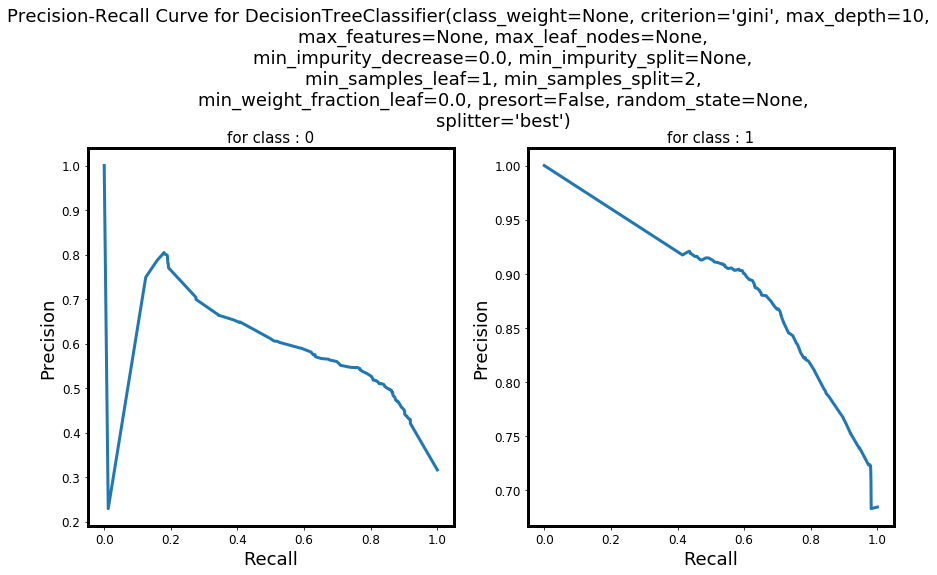

                estimator  N_sample  poly_feature          scaler  fit_time  \
0  RandomForestClassifier     20000             0  StandardScaler  4.386924   

   score_time  test_score  train_score  
0    0.168504    0.832866          1.0  
----------------------------
##################################################################
Test Score on test set : 0.8276
----------------------------
Confusion Matirix : 

[[ 869  711]
 [ 151 3269]]
----------------------------
              precision    recall  f1-score   support

           0       0.85      0.55      0.67      1580
           1       0.82      0.96      0.88      3420

   micro avg       0.83      0.83      0.83      5000
   macro avg       0.84      0.75      0.78      5000
weighted avg       0.83      0.83      0.82      5000

----------------------------
AUC : 0.7529239766081872
----------------------------


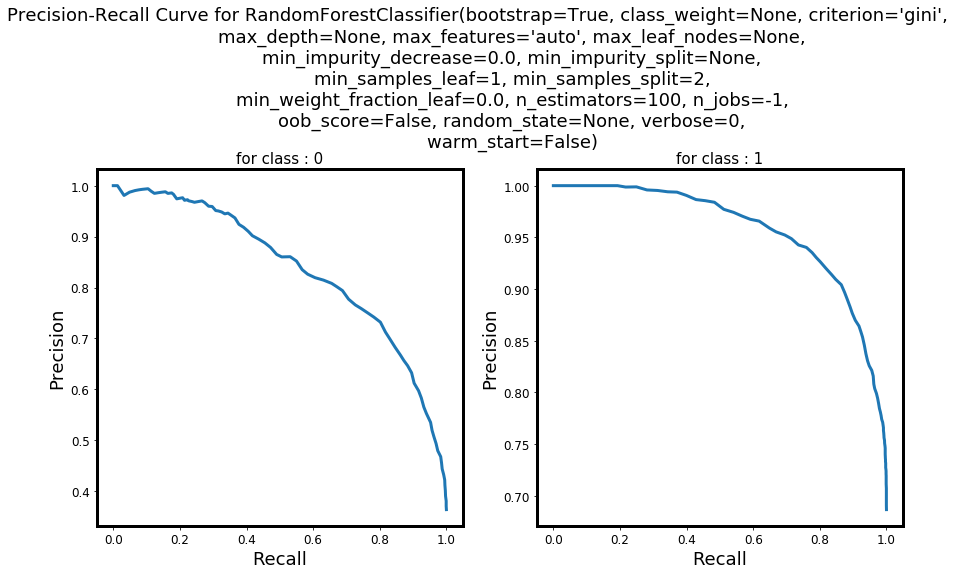

              estimator  N_sample  poly_feature          scaler  fit_time  \
0  ExtraTreesClassifier     20000             0  StandardScaler  0.224066   

   score_time  test_score  train_score  
0    0.109151    0.804733          1.0  


/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


----------------------------
##################################################################
Test Score on test set : 0.8012
----------------------------
Confusion Matirix : 

[[1024  556]
 [ 438 2982]]
----------------------------
              precision    recall  f1-score   support

           0       0.70      0.65      0.67      1580
           1       0.84      0.87      0.86      3420

   micro avg       0.80      0.80      0.80      5000
   macro avg       0.77      0.76      0.77      5000
weighted avg       0.80      0.80      0.80      5000

----------------------------
AUC : 0.7600155451920942
----------------------------


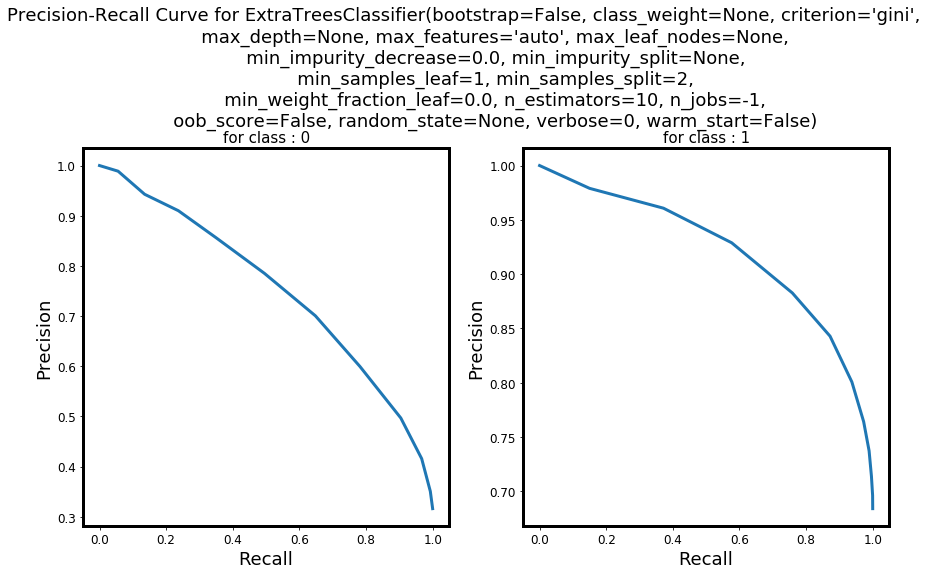

/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


  estimator  N_sample  poly_feature          scaler  fit_time  score_time  \
0       SVC     20000             0  StandardScaler  6.782739    0.924937   

   test_score  train_score  
0       0.859     0.883117  


/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


----------------------------
##################################################################
Test Score on test set : 0.8666
----------------------------
Confusion Matirix : 

[[1157  423]
 [ 244 3176]]
----------------------------
              precision    recall  f1-score   support

           0       0.83      0.73      0.78      1580
           1       0.88      0.93      0.90      3420

   micro avg       0.87      0.87      0.87      5000
   macro avg       0.85      0.83      0.84      5000
weighted avg       0.86      0.87      0.86      5000

----------------------------
AUC : 0.830466725886446
----------------------------


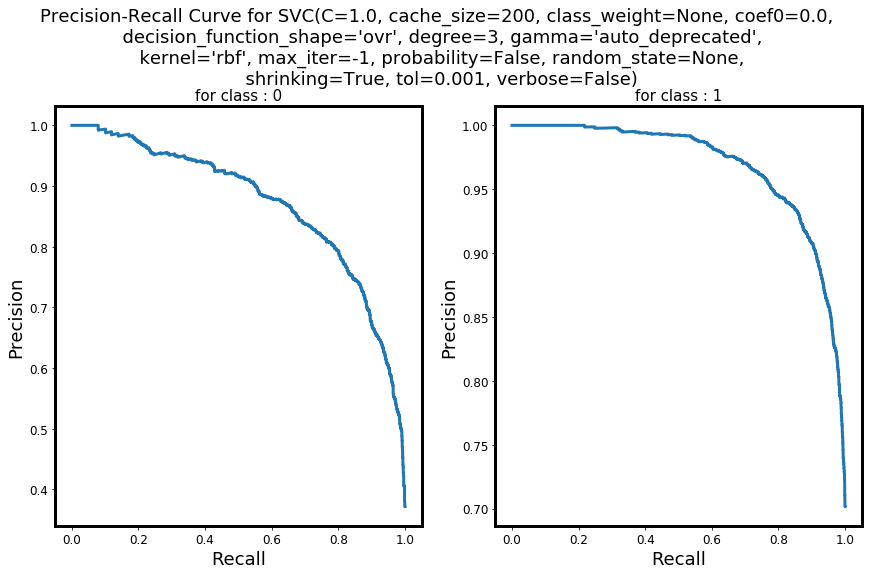

              estimator  N_sample  poly_feature          scaler  fit_time  \
0  KNeighborsClassifier     20000             0  StandardScaler  0.020185   

   score_time  test_score  train_score  
0    2.013179    0.776266     0.863533  
----------------------------
##################################################################
Test Score on test set : 0.7878
----------------------------
Confusion Matirix : 

[[1320  260]
 [ 801 2619]]
----------------------------
              precision    recall  f1-score   support

           0       0.62      0.84      0.71      1580
           1       0.91      0.77      0.83      3420

   micro avg       0.79      0.79      0.79      5000
   macro avg       0.77      0.80      0.77      5000
weighted avg       0.82      0.79      0.79      5000

----------------------------
AUC : 0.8006162558294471
----------------------------


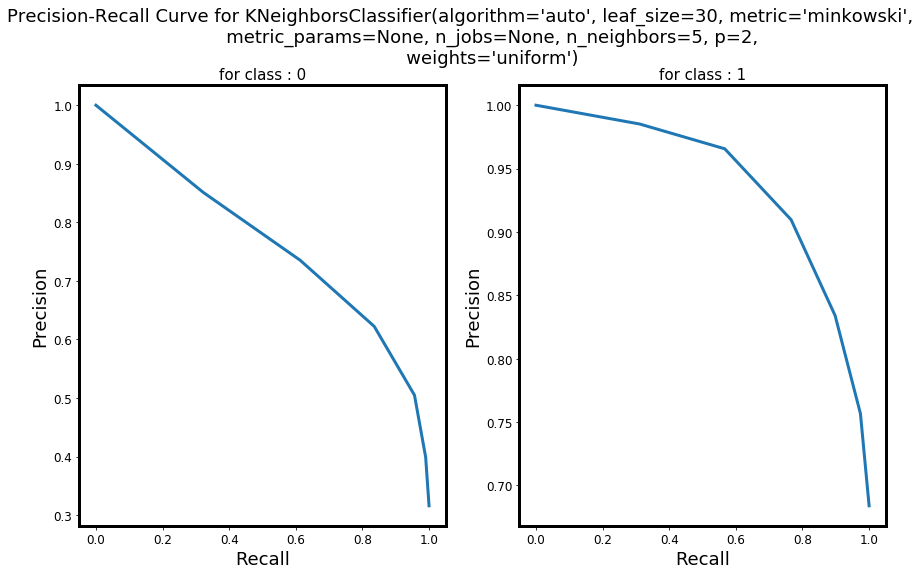

In [91]:
clf_list = [
#   DummyClassifier(strategy='most_frequent'),
#   RidgeClassifier(),
#   SGDClassifier(),
#   GaussianNB(),
  DecisionTreeClassifier(max_depth=10),
  RandomForestClassifier(n_estimators=100,n_jobs=-1),
  ExtraTreesClassifier(n_jobs=-1),
  SVC(), #O(N^2)
  KNeighborsClassifier(), #O(N^2)
#   BaggingClassifier(),
#   GradientBoostingClassifier(),
#   AdaBoostClassifier()
]

reg_list=[
#     LinearRegression(),
#     Ridge(),
#     Lasso(),
#     DecisionTreeRegressor(),
#     RandomForestRegressor(n_estimators=100),
#     SVR(),
#     SVR(kernel='poly',degree=4),
#     KNeighborsRegressor()
]
##################################################################################

clf_reg_list = [my_clf_from_reg(regs) for regs in reg_list ]
table_clf=pd.DataFrame()

def reg_scoring(estimator,X,y): #for reg to clf
      return estimator.score(X,y<0)

if is_clf :
  scoring=None
else:
  scoring=reg_scoring
  


#with open('clf_analysis.txt', 'w') as f:
#    with redirect_stdout(f):
#        print('hi')

# for clf in clf_reg_list:

if not is_clf: clf_list = clf_reg_list

for clf in clf_list:
  
  info = pd.DataFrame()
  info['estimator'] =[str(clf).split('(')[0]]
  info['N_sample']= N_sample
  info['poly_feature']=poly_feature
  info['scaler']= scaler
  
  info_dict = cross_validate(clf,X_train,y_train,scoring=scoring,cv=5,n_jobs=-1,verbose=0,return_train_score=True)
  info_mean = pd.DataFrame({key:[info_dict[key].mean()] for key in info_dict.keys()})
  
  info=pd.concat([info,info_mean],axis=1)
  
  print(info)
  table_clf=table_clf.append(info,ignore_index=True)
  
  clf.fit(X_train,y_train)
  print('----------------------------')
  if not is_clf:
    y_testt = y_test<0
  else:
    y_testt = y_test
  my_clf_score_analyze(clf,X_test,y_testt)
  precision, recall, thresholds = my_precision_recall_curve(clf,X_test,y_testt)

In [100]:
table_clf.to_csv('table_clf.csv',index=False)
table_clf

,estimator,N_sample,poly_feature,scaler,fit_time,score_time,test_score,train_score
0,RandomForestClassifier,1000000,0,StandardScaler,489.277723,7.171384,0.882805,1.0


## Learning curve

######################
Last Training Score : 0.8283023585298774
Last Validation score : 0.7448666996740778
######################


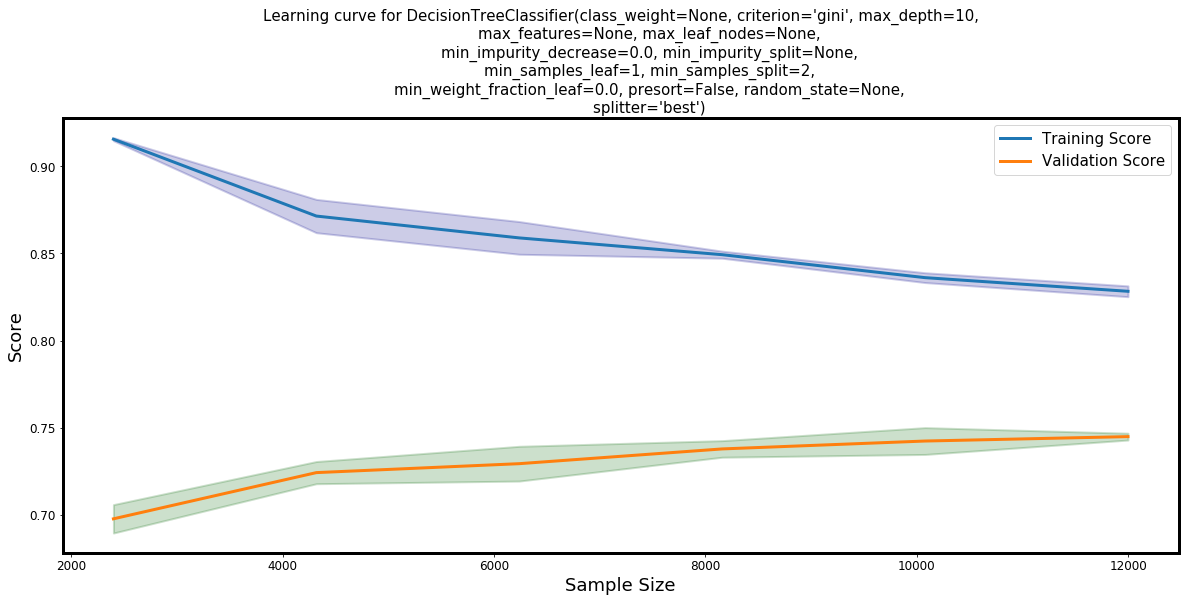

######################
Last Training Score : 1.0
Last Validation score : 0.8307994591554954
######################


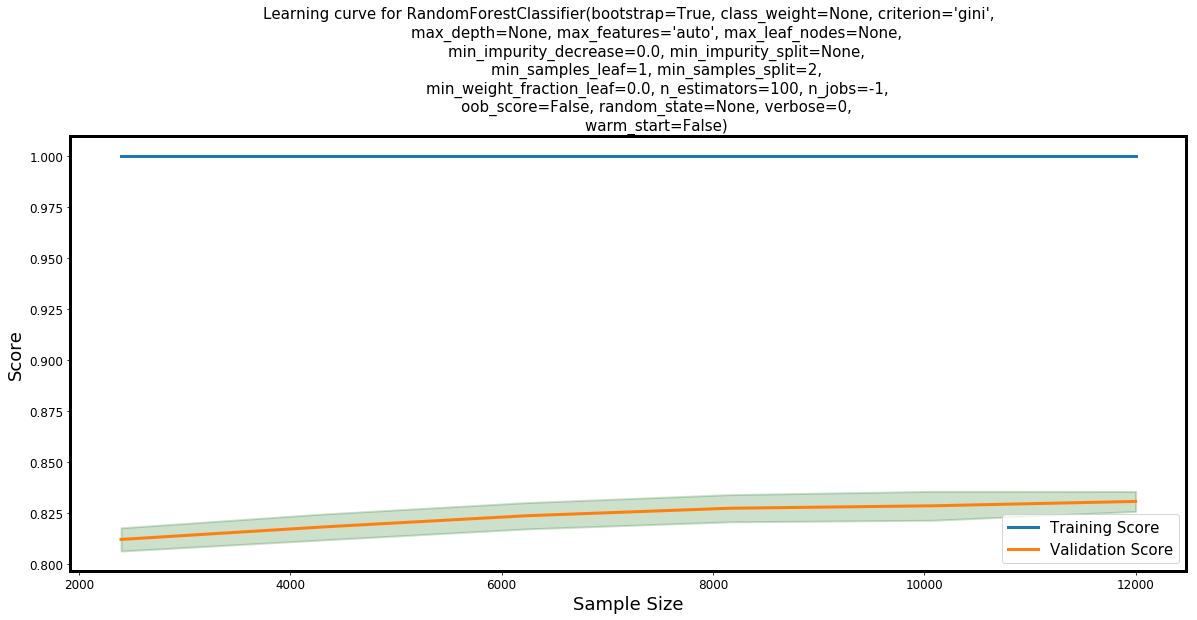

######################
Last Training Score : 1.0
Last Validation score : 0.8066664360444188
######################


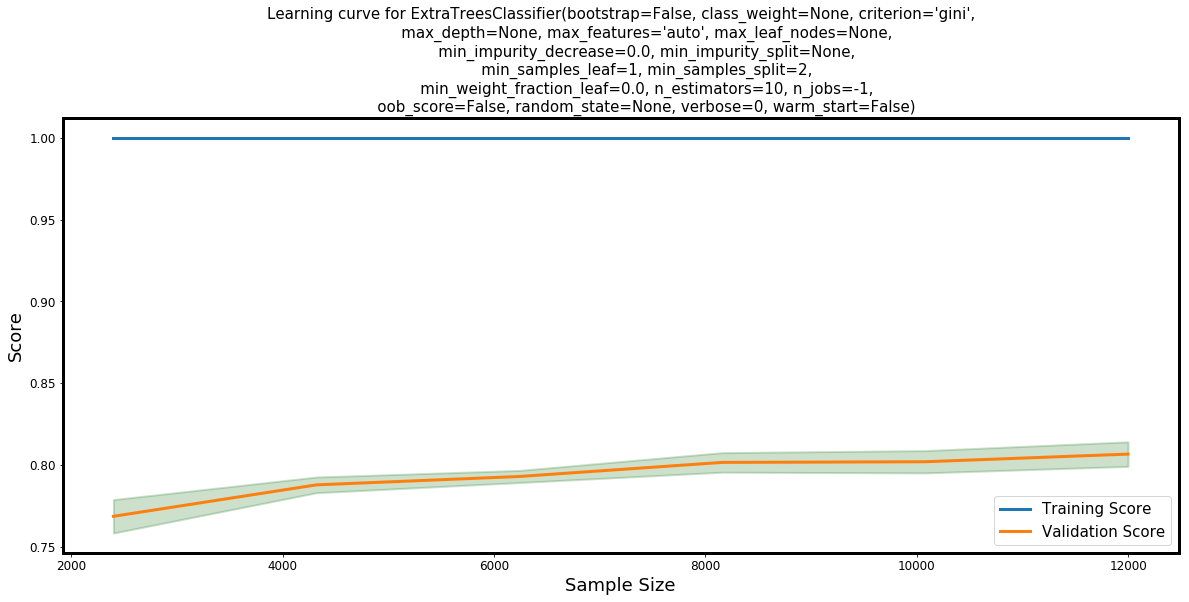

######################
Last Training Score : 0.8831735977998166
Last Validation score : 0.858866993918555
######################


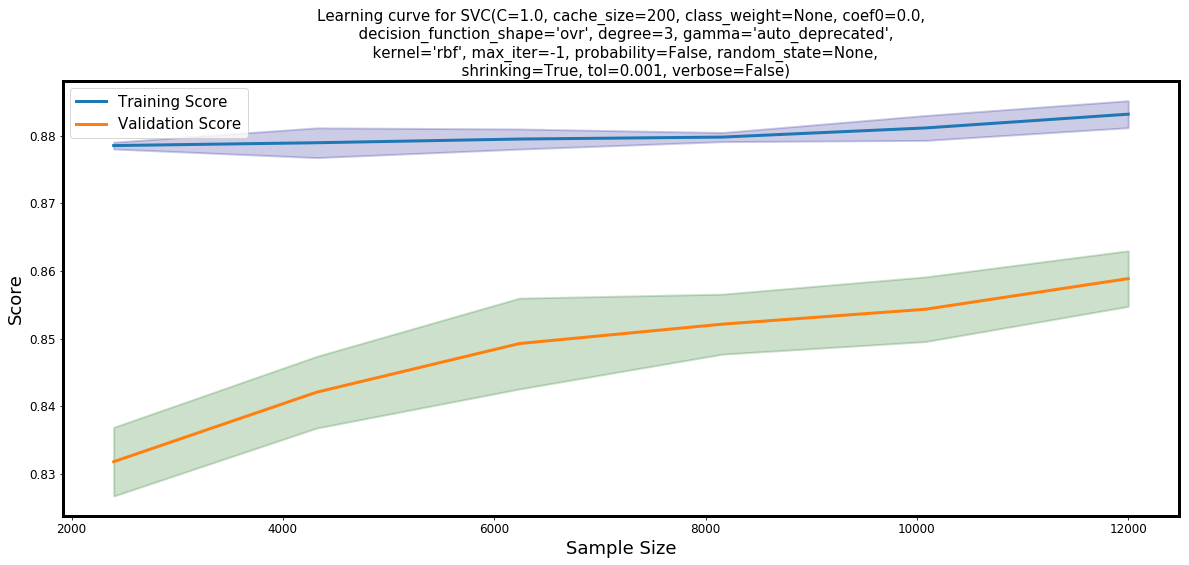

######################
Last Training Score : 0.8635552962746896
Last Validation score : 0.7761992342962112
######################


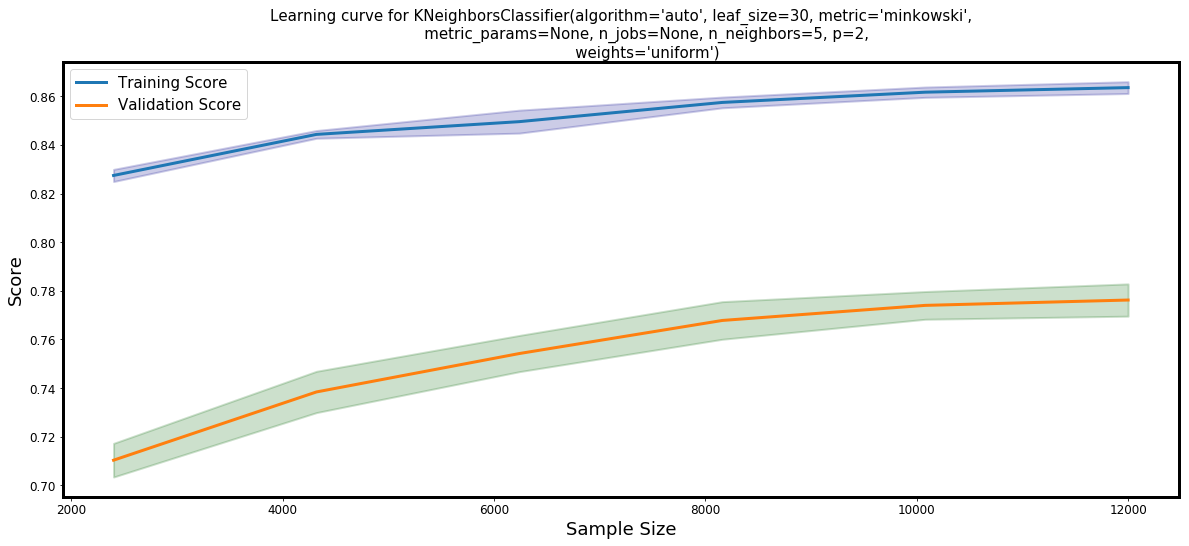

In [92]:
train_sizes = list(np.linspace(0.2,1,6)) #for learning curve

for clf in clf_list:
  train_size, train_scores, validation_scores = my_learning_curve(estimator=clf, X=X_train, y=y_train, train_sizes=train_sizes, cv=5, n_jobs=-1, verbose=0)


### Variance and Bias Analysis

According to Learning curves, the classifier made from Linear Regression and Ridge with polynomial transform, has a small variance and also a small bias. Other models such as SVC has a high bias and an small variance, which means more data will not enhance its performance. On the othe hand, classifiers and regressors based on tree, has a high variance but small biases, which means that if we provide more data for them, there will be an increase in their perfomance. With increasing data to 1 milion samples, the RandomForestClassifier Obtain a better score. Further increase of data samples will not increase the performance, although the variance remained larg yet.

## Table of Comparision
in this section we gather the Scores from several Methods (Regression and Classification) used above and show them in a Table :

In [106]:
# final_table_clf=pd.DataFrame()
final_table_clf=pd.read_csv('https://www.dropbox.com/s/utzzsf2vnph4vzi/final_table_clf.csv?dl=1')
final_table_clf.sort_values('test_score',ascending=False).reset_index(drop=True)

,estimator,N_sample,poly_feature,scaler,fit_time,score_time,test_score,train_score
0,LinearRegression,20000,4,StandardScaler,85.136894,0.063321,0.996933,0.996933
1,Ridge,20000,4,StandardScaler,11.969841,0.046773,0.991000,0.992167
2,RandomForestClassifier,1000000,0,StandardScaler,489.277723,7.171384,0.882805,1.000000
3,SVC,50000,0,StandardScaler,31.243196,4.636604,0.879600,0.895647
4,SVR,10000,0,StandardScaler,5.256612,0.432860,0.876267,0.894133
5,RandomForestClassifier,50000,0,StandardScaler,11.762246,0.226973,0.847440,1.000000
6,RandomForestRegressor,50000,0,StandardScaler,72.659766,0.351008,0.847067,0.942207
7,SGDClassifier,20000,4,StandardScaler,1.462001,0.032926,0.846801,0.904367
8,SVR_poly_degree_4,10000,0,StandardScaler,7.652852,0.206586,0.832533,0.870533
9,BaggingClassifier,50000,0,StandardScaler,5.181504,0.024030,0.831920,0.994580


## Validation curve

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0525s.) Setting batch_size=6.
[Parallel(n_jobs=-1)]: Done   6 out of  40 | elapsed:    0.4s remaining:    2.3s
[Parallel(n_jobs=-1)]: Done  11 out of  40 | elapsed:    0.6s remaining:    1.7s
[Parallel(n_jobs=-1)]: Done  16 out of  40 | elapsed:    0.9s remaining:    1.3s
[Parallel(n_jobs=-1)]: Done  21 out of  40 | elapsed:    1.2s remaining:    1.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    2.3s finished


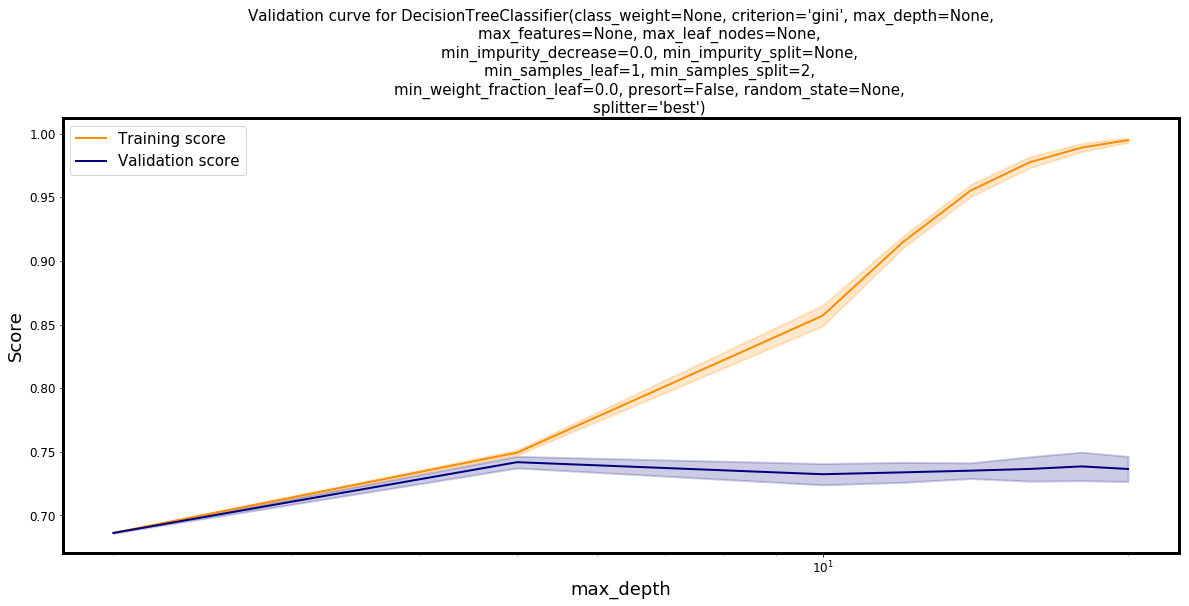

In [66]:
### validation_curve
estimator = DecisionTreeClassifier()
param_name = 'max_depth'
param_range = [2,5,10,12,14,16,18,20]
train_scores, valid_scores = my_validation_curve(estimator,param_name,param_range,X_train,y_train,cv=5)

## feature_selection / feature importance

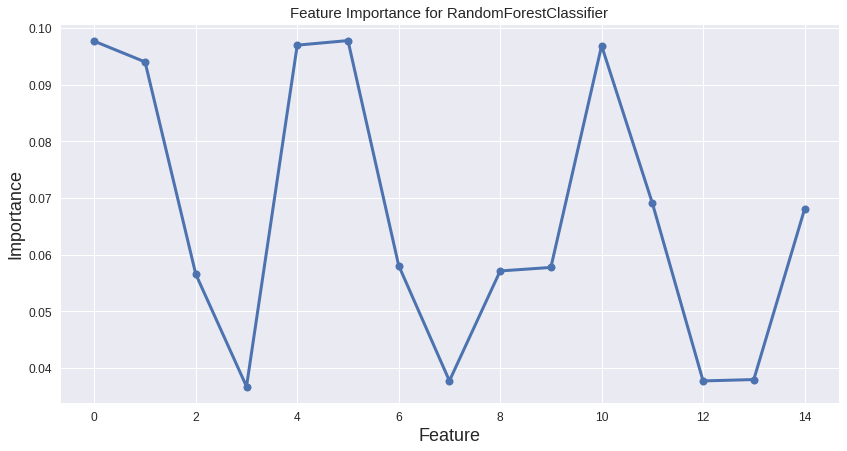

In [0]:
plt_title = 'Feature Importance for {}'.format(str(estimator))
x_label = 'Feature'
y_label = 'Importance'
fig = plt.figure(figsize=(14,7))
ax = fig.add_subplot(111,xlabel=x_label, ylabel = y_label, title = plt_title)


feature_importances = opt_estimator.feature_importances_
ax.plot(  np.arange(feature_importances.size) , feature_importances ,marker='o',markersize=8 )

# feature_importances = opt_estimator.coef_
# plt.scatter(  np.arange(feature_importances.size).reshape(1,-1) , feature_importances  )

plt.show()

In [0]:
ind =[0,1,4,5,10]

### manual feature reduction

In [0]:
'''
Let's pick the first m more important features. 
'''
m=8
opt_estimator=RandomForestClassifier(n_estimators=100,verbose=10,n_jobs=-1)
index_imfr = ind#np.argsort( feature_importances   )[::-1][:m]

reduced_x_train = X_train[:,index_imfr ]
reduced_x_test = X_test[ :,index_imfr ]

opt_estimator.fit(reduced_x_train, y_train)
print('Score with data reduction is: {}'.format(  opt_estimator.score(reduced_x_test, y_test)  ))
print(index_imfr)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.


building tree 1 of 100building tree 2 of 100



[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    3.5s


building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100


[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    7.6s


building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   19.5s


building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100


[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:   27.4s


building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100


[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:   43.1s


building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100


[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   56.6s


building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100


[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  1.3min


building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
building tree 43 of 100
building tree 44 of 100
building tree 45 of 100
building tree 46 of 100
building tree 47 of 100


[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  1.6min


building tree 48 of 100
building tree 49 of 100
building tree 50 of 100
building tree 51 of 100
building tree 52 of 100
building tree 53 of 100
building tree 54 of 100
building tree 55 of 100
building tree 56 of 100
building tree 57 of 100
building tree 58 of 100
building tree 59 of 100


[Parallel(n_jobs=-1)]: Done  57 tasks      | elapsed:  2.0min


building tree 60 of 100
building tree 61 of 100
building tree 62 of 100
building tree 63 of 100
building tree 64 of 100
building tree 65 of 100
building tree 66 of 100
building tree 67 of 100
building tree 68 of 100
building tree 69 of 100
building tree 70 of 100


[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:  2.3min


building tree 71 of 100
building tree 72 of 100
building tree 73 of 100
building tree 74 of 100
building tree 75 of 100
building tree 76 of 100
building tree 77 of 100
building tree 78 of 100
building tree 79 of 100
building tree 80 of 100
building tree 81 of 100
building tree 82 of 100
building tree 83 of 100


[Parallel(n_jobs=-1)]: Done  81 tasks      | elapsed:  2.8min


building tree 84 of 100
building tree 85 of 100
building tree 86 of 100
building tree 87 of 100
building tree 88 of 100
building tree 89 of 100
building tree 90 of 100
building tree 91 of 100
building tree 92 of 100
building tree 93 of 100
building tree 94 of 100
building tree 95 of 100


[Parallel(n_jobs=-1)]: Done  94 tasks      | elapsed:  3.2min


building tree 96 of 100
building tree 97 of 100
building tree 98 of 100
building tree 99 of 100
building tree 100 of 100


[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  3.4min finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   1 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done   4 tasks      | elapsed:    0.2s
[Parallel(n_jobs=2)]: Done   9 tasks      | elapsed:    0.6s
[Parallel(n_jobs=2)]: Done  14 tasks      | elapsed:    0.8s
[Parallel(n_jobs=2)]: Done  21 tasks      | elapsed:    1.3s
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:    1.6s
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    2.2s
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    2.7s
[Parallel(n_jobs=2)]: Done  57 tasks      | elapsed:    3.3s
[Parallel(n_jobs=2)]: Done  68 tasks      | elapsed:    3.9s
[Parallel(n_jobs=2)]: Done  81 tasks      | elapsed:    4.7s
[Parallel(n_jobs=2)]: Done  94 tasks      | elapsed:    5.4s


Score with data reduction is: 0.77722
[0, 1, 4, 5, 10]


[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    5.8s finished


### SelectFromModel

In [0]:
'''
model = SelectFromModel(opt_estimator, threshold='median')
reduced_x_train = model.fit_transform(x_train,y_train)
print('{} feature selection: with {} features.'.format(estim,reduced_x_train.shape[1] ))

sm_scores = cross_val_score(opt_estimator,  reduced_x_train , y_train , cv=5, n_jobs=-1)
reduced_x_test = model.transform(x_test)

print('The cv scores are:\n {}'.format(sm_scores))
print('test score : {}'.format(opt_estimator.score(reduced_x_test,y_test)))
'''

### RFE

In [0]:
rfe = RFE(estimator=opt_estimator, n_features_to_select=8, step=0.5, verbose=10)
rfe.fit(x_train, y_train)
# rfe.estimator_
reduced_x_train = rfe.transform(x_train)
reduced_x_test = rfe.transform(x_test)

print('{} feature selection: with {} features.'.format(estim,rfe.n_features_ ))

rfs_scores = cross_val_score(opt_estimator,  reduced_x_train , y_train , cv=5, n_jobs=-1,verbose=10)

print('The cv scores are:\n {}'.format(rfs_scores))
print('Test Score : {}'.format(rfe.estimator_.score(reduced_x_test,y_test)))

Fitting estimator with 15 features.
RandomForestClassifier feature selection: with 8 features.


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   14.0s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:   26.5s remaining:   17.7s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   35.8s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   35.8s finished


The cv scores are:
 [0.82734915 0.82331802 0.822375   0.82352574 0.82308822]
Test Score : 0.8305
Test Score : 0.8314


[ True  True False False  True  True  True False False False  True  True
 False False  True]
[1 1 4 6 1 1 1 8 2 3 1 1 5 7 1]


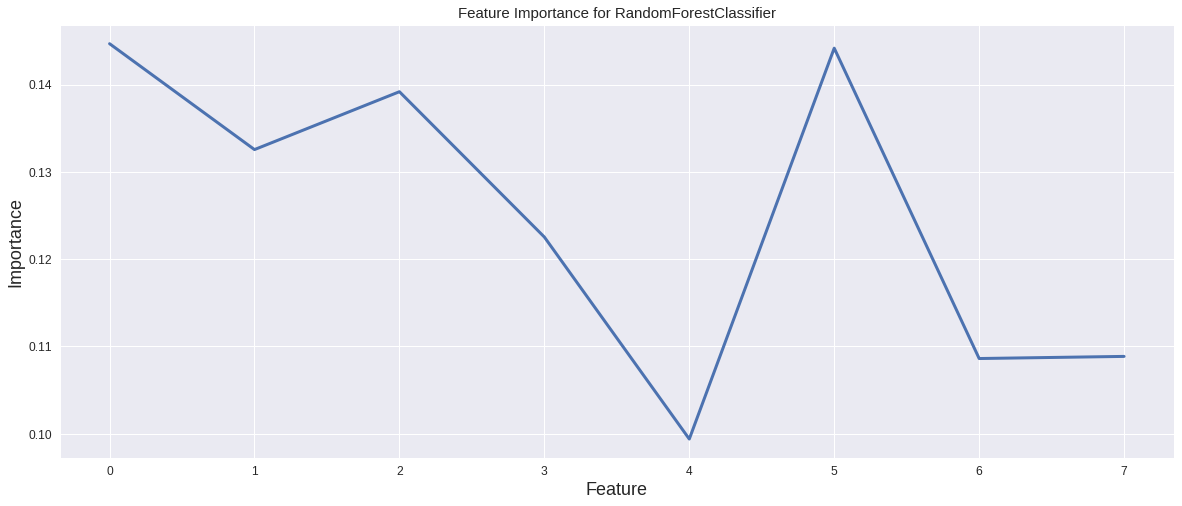

In [0]:
plt_title = 'Feature Importance for {}'.format(estimator)
x_label = 'Feature'
y_label = 'Importance'
fig = plt.figure()
ax = fig.add_subplot(111,xlabel=x_label, ylabel = y_label, title = plt_title)
feature_importances = rfe.estimator_.feature_importances_
ax.plot(  np.arange(feature_importances.size) , feature_importances  )
#print(rfe.support_)
print(rfe.ranking_)

### PCA

In [0]:
pca = PCA()
X_train_red = pca.fit_transform(X_train)

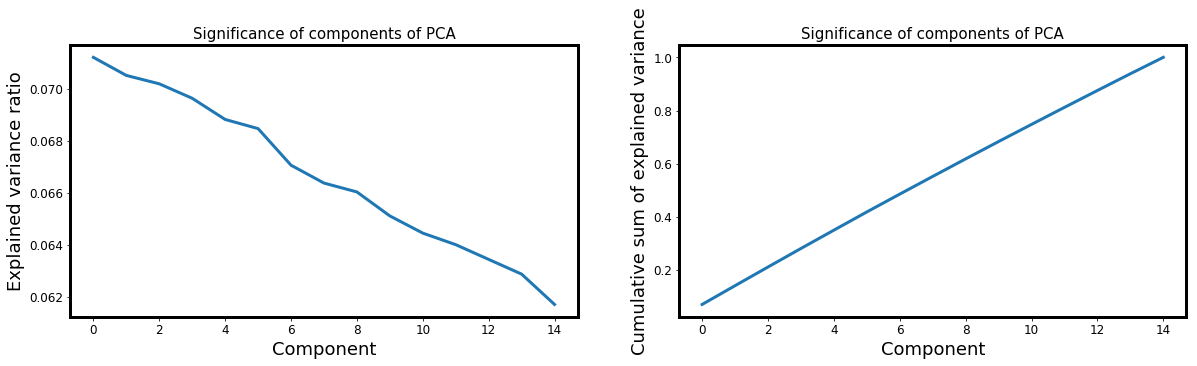

In [76]:
fig = plt.figure(figsize=(20,5))
ax1 = fig.add_subplot(1,2,1, title = 'Significance of components of PCA', xlabel='Component', ylabel='Explained variance ratio')
ax1.plot(pca.explained_variance_ratio_)
ax1 = fig.add_subplot(1,2,2, title = 'Significance of components of PCA', xlabel='Component', ylabel='Cumulative sum of explained variance')
ax1.plot(np.cumsum(pca.explained_variance_ratio_))

plt.show()

In [0]:
pca = PCA(n_components=8)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

                estimator  N_sample  poly_feature          scaler  fit_time  \
0  RandomForestClassifier     10000             0  StandardScaler   1.62691   

   score_time  test_score  train_score  
0    0.102501    0.746134          1.0  
----------------------------
##################################################################
Test Score on test set : 0.754
----------------------------
Confusion Matirix : 

[[ 337  447]
 [ 168 1548]]
----------------------------
              precision    recall  f1-score   support

           0       0.67      0.43      0.52       784
           1       0.78      0.90      0.83      1716

   micro avg       0.75      0.75      0.75      2500
   macro avg       0.72      0.67      0.68      2500
weighted avg       0.74      0.75      0.74      2500

----------------------------
AUC : 0.6659724204367061
----------------------------


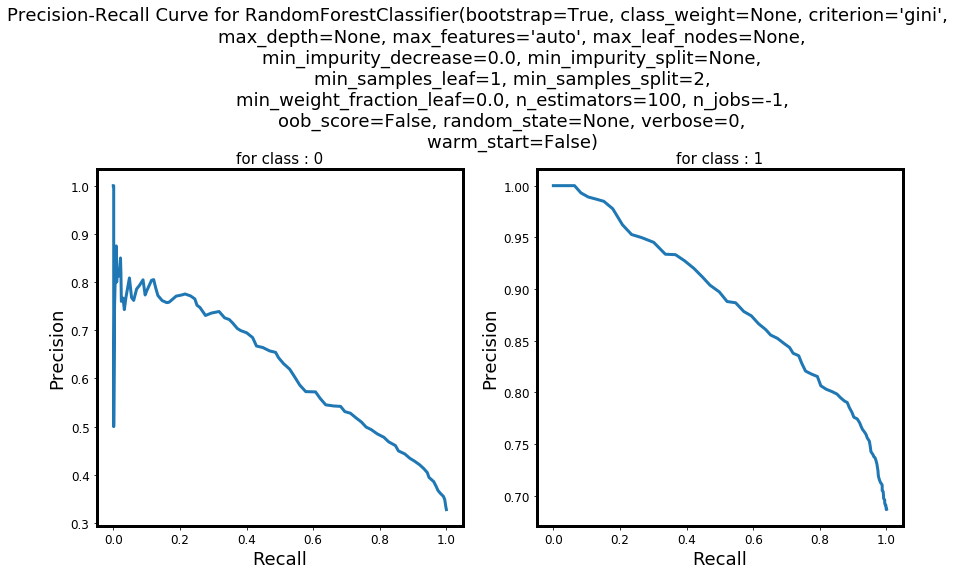

In [82]:
clf_list = [
#   DummyClassifier(strategy='most_frequent'),
#   RidgeClassifier(),
#   SGDClassifier(),
#   GaussianNB(),
#   DecisionTreeClassifier(max_depth=10),
  RandomForestClassifier(n_estimators=100,n_jobs=-1),
#   ExtraTreesClassifier(n_jobs=-1),
#   SVC(), #O(N^2)
#   KNeighborsClassifier(), #O(N^2)
#   BaggingClassifier(),
#   GradientBoostingClassifier(),
#   AdaBoostClassifier()
]

reg_list=[
#     LinearRegression(),
#     Ridge(),
#     Lasso(),
#     DecisionTreeRegressor(),
#     RandomForestRegressor(n_estimators=100),
#     SVR(),
#     SVR(kernel='poly',degree=4),
#     KNeighborsRegressor()
]
##################################################################################

clf_reg_list = [my_clf_from_reg(regs) for regs in reg_list ]
table_clf=pd.DataFrame()

def reg_scoring(estimator,X,y): #for reg to clf
      return estimator.score(X,y<0)

if is_clf :
  scoring=None
else:
  scoring=reg_scoring
  


#with open('clf_analysis.txt', 'w') as f:
#    with redirect_stdout(f):
#        print('hi')

# for clf in clf_reg_list:

if not is_clf: clf_list = clf_reg_list

for clf in clf_list:
  
  info = pd.DataFrame()
  info['estimator'] =[str(clf).split('(')[0]]
  info['N_sample']= N_sample
  info['poly_feature']=poly_feature
  info['scaler']= scaler
  
  info_dict = cross_validate(clf,X_train_pca,y_train,scoring=scoring,cv=5,n_jobs=-1,verbose=0,return_train_score=True)
  info_mean = pd.DataFrame({key:[info_dict[key].mean()] for key in info_dict.keys()})
  
  info=pd.concat([info,info_mean],axis=1)
  
  print(info)
  table_clf=table_clf.append(info,ignore_index=True)
  
  clf.fit(X_train_pca,y_train)
  print('----------------------------')
  if not is_clf:
    y_testt = y_test<0
  else:
    y_testt = y_test
  my_clf_score_analyze(clf,X_test_pca,y_testt)
  precision, recall, thresholds = my_precision_recall_curve(clf,X_test_pca,y_testt)

In [83]:
table_clf.to_csv('table_clf.csv',index=False)
table_clf

,estimator,N_sample,poly_feature,scaler,fit_time,score_time,test_score,train_score
0,RandomForestClassifier,10000,0,StandardScaler,1.62691,0.102501,0.746134,1.0


### Manifold

In [84]:
tsne = TSNE()
X_tsne = tsne.fit_transform(X)
X_train_tsne , X_test_tsne , y_train , y_test= train_test_split(X,y)

/usr/local/lib/python3.6/dist-packages/numpy/matrixlib/defmatrix.py:71: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/usr/local/lib/python3.6/dist-packages/numpy/matrixlib/defmatrix.py:71: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)


                estimator  N_sample  poly_feature          scaler  fit_time  \
0  RandomForestClassifier     10000             0  StandardScaler  1.852305   

   score_time  test_score  train_score  
0    0.102946    0.813467          1.0  
----------------------------
##################################################################
Test Score on test set : 0.8156
----------------------------
Confusion Matirix : 

[[ 421  401]
 [  60 1618]]
----------------------------
              precision    recall  f1-score   support

           0       0.88      0.51      0.65       822
           1       0.80      0.96      0.88      1678

   micro avg       0.82      0.82      0.82      2500
   macro avg       0.84      0.74      0.76      2500
weighted avg       0.83      0.82      0.80      2500

----------------------------
AUC : 0.7382042983623767
----------------------------


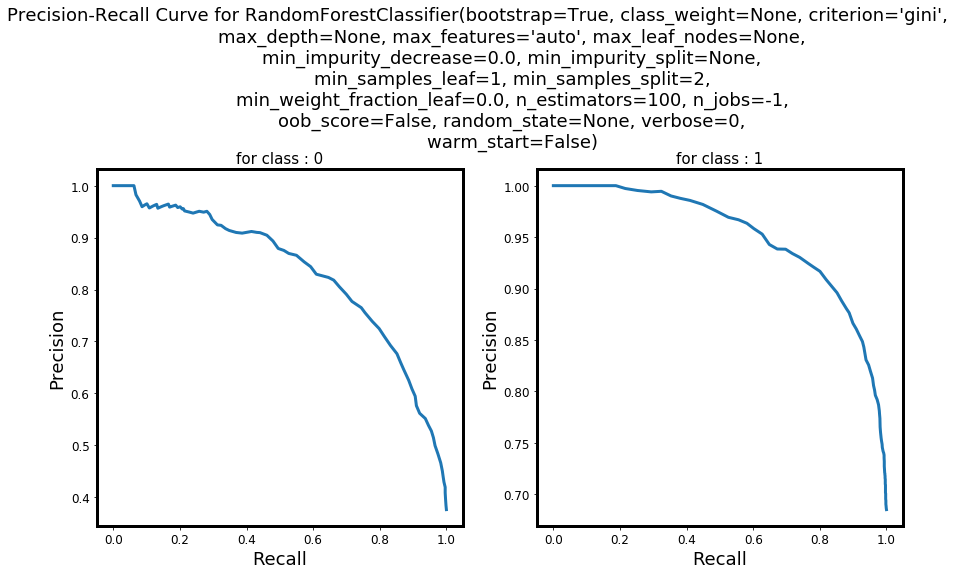

In [85]:
clf_list = [
#   DummyClassifier(strategy='most_frequent'),
#   RidgeClassifier(),
#   SGDClassifier(),
#   GaussianNB(),
#   DecisionTreeClassifier(max_depth=10),
  RandomForestClassifier(n_estimators=100,n_jobs=-1),
#   ExtraTreesClassifier(n_jobs=-1),
#   SVC(), #O(N^2)
#   KNeighborsClassifier(), #O(N^2)
#   BaggingClassifier(),
#   GradientBoostingClassifier(),
#   AdaBoostClassifier()
]

reg_list=[
#     LinearRegression(),
#     Ridge(),
#     Lasso(),
#     DecisionTreeRegressor(),
#     RandomForestRegressor(n_estimators=100),
#     SVR(),
#     SVR(kernel='poly',degree=4),
#     KNeighborsRegressor()
]
##################################################################################

clf_reg_list = [my_clf_from_reg(regs) for regs in reg_list ]
table_clf=pd.DataFrame()

def reg_scoring(estimator,X,y): #for reg to clf
      return estimator.score(X,y<0)

if is_clf :
  scoring=None
else:
  scoring=reg_scoring
  


#with open('clf_analysis.txt', 'w') as f:
#    with redirect_stdout(f):
#        print('hi')

# for clf in clf_reg_list:

if not is_clf: clf_list = clf_reg_list

for clf in clf_list:
  
  info = pd.DataFrame()
  info['estimator'] =[str(clf).split('(')[0]]
  info['N_sample']= N_sample
  info['poly_feature']=poly_feature
  info['scaler']= scaler
  
  info_dict = cross_validate(clf,X_train_tsne,y_train,scoring=scoring,cv=5,n_jobs=-1,verbose=0,return_train_score=True)
  info_mean = pd.DataFrame({key:[info_dict[key].mean()] for key in info_dict.keys()})
  
  info=pd.concat([info,info_mean],axis=1)
  
  print(info)
  table_clf=table_clf.append(info,ignore_index=True)
  
  clf.fit(X_train_tsne,y_train)
  print('----------------------------')
  if not is_clf:
    y_testt = y_test<0
  else:
    y_testt = y_test
  my_clf_score_analyze(clf,X_test_tsne,y_testt)
  precision, recall, thresholds = my_precision_recall_curve(clf,X_test_tsne,y_testt)

## NN

In [0]:
#multi class
from keras.utils import to_categorical
y_binary_train = to_categorical(y_train)
y_binary_test = to_categorical(y_test)
## categorical_crossentropy

Using TensorFlow backend.


### Build Model

In [0]:

### define model
model_name = 'B' # model name
model = tf.keras.models.Sequential()
##### reduced_x_train
model.add(tf.keras.layers.Dense(5, activation='linear' , input_dim=X.shape[1] ))

model.add(tf.keras.layers.Dense(512, activation='relu' ))#X.shape[1]))
# model.add(tf.keras.layers.Dropout(0.25))

model.add(tf.keras.layers.Dense(512, activation='relu'  ))
# model.add(tf.keras.layers.Dropout(0.25))

model.add(tf.keras.layers.Dense(512, activation='relu' ))
# model.add(tf.keras.layers.Dropout(0.25))

model.add(tf.keras.layers.Dense(512, activation='relu' ))
# model.add(tf.keras.layers.Dropout(0.25))

# model.add(tf.keras.layers.Dense(4000, activation='relu' ))
# model.add(tf.keras.layers.Dense(50, activation='relu'  ))
# model.add(tf.keras.layers.Dropout(0.2))

model.add(tf.keras.layers.Dense(1, activation='sigmoid'))
# tf.keras.layers.Flatten #conv2d
## compile model

model.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(lr=0.001), metrics=['accuracy'])


with open('model_{}_summary.txt'.format(model_name), 'w') as f:
    with redirect_stdout(f):
        model.summary()

In [0]:
NN_model = tf.keras.models.Sequential()

# The Input Layer :
NN_model.add(tf.keras.layers.Dense(128, kernel_initializer='normal',input_dim = X_train.shape[1], activation='relu'))

# The Hidden Layers :
NN_model.add(tf.keras.layers.Dense(256, kernel_initializer='normal',activation='relu'))
NN_model.add(tf.keras.layers.Dense(256, kernel_initializer='normal',activation='relu'))
NN_model.add(tf.keras.layers.Dense(256, kernel_initializer='normal',activation='relu'))

# The Output Layer :
NN_model.add(tf.keras.layers.Dense(1, kernel_initializer='normal',activation='linear'))

# Compile the network :
NN_model.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mean_absolute_error'])
NN_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_13 (Dense)             (None, 128)               2048      
_________________________________________________________________
dense_14 (Dense)             (None, 256)               33024     
_________________________________________________________________
dense_15 (Dense)             (None, 256)               65792     
_________________________________________________________________
dense_16 (Dense)             (None, 256)               65792     
_________________________________________________________________
dense_17 (Dense)             (None, 1)                 257       
Total params: 166,913
Trainable params: 166,913
Non-trainable params: 0
_________________________________________________________________


In [0]:
net = 'A'
#saves the model weights after each epoch if the validation loss decreased
checkpointer = tf.keras.callbacks.ModelCheckpoint(filepath='weights_{}_net_{}.hdf5'.format(model_name,net), verbose=1, save_best_only=True)

### Train Model

In [0]:
load_net = 'A'
# model.load_weights('weights_{}_net_{}.hdf5'.format(model_name,load_net))
model.evaluate(X_test,y_test)

250000/250000 [==============================] - 19s 74us/sample - loss: 0.2812 - acc: 0.8671


[0.28120395925235747, 0.8671]

In [0]:
X_train ,X_val, X_test = 0.6 , 0.2 , 0.2 ==> 0.8 0.1 0.1 (1M)
X_train , X_val = 0.8 0.2

In [0]:
batch_size = int(.0002*.8*len(X)) #32 , 64:0.718 ,128: , 256:0.692 , 512: , 1024: , 2*1024: , 4*1024: 0.654 , 8*1024: 0.648 , 16*1024:0.603
print(batch_size)
#set early stopping monitor so the model stops training when it won't improve anymore #batch_itr*itr
#early_stopping_monitor = tf.keras.callbacks.EarlyStopping(patience=10)

#train model
model.fit(X_train,y_train, epochs=40  , validation_split=0.2   , batch_size = batch_size )#,callbacks=[checkpointer]) #, callbacks=[early_stopping_monitor, checkpointer]

### Score

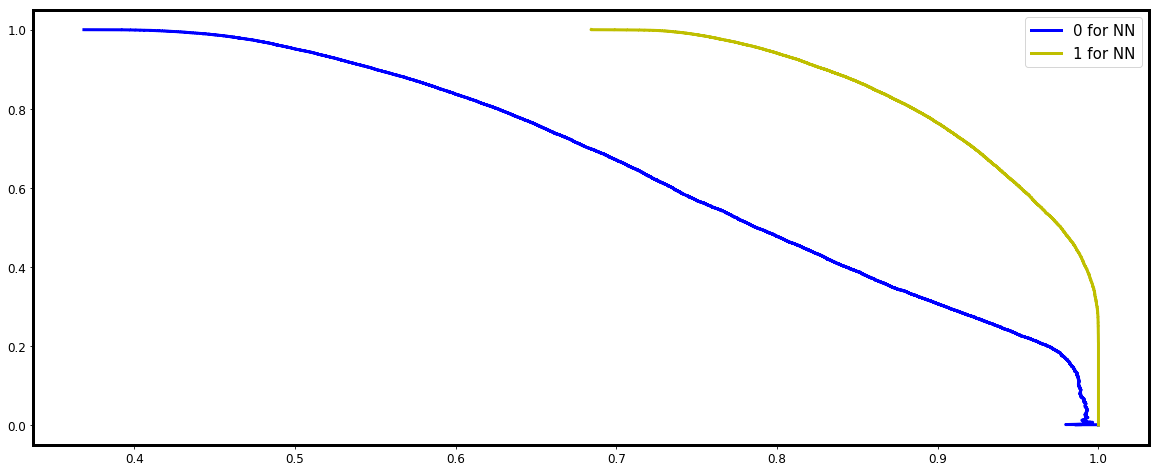

In [0]:

# precision, recall, thresholds = precision_recall_curve(y_test, decision_values_tree[:,0],pos_label=0)
# plt.plot(precision,recall,c='r',label='0 for tree')

# precision, recall, thresholds = precision_recall_curve(y_test, decision_values_tree[:,1],pos_label=1)
# plt.plot(precision,recall,c='g',label='1 for tree')

##########


decision_values_NN = model.predict(X_test)
precision, recall, thresholds = precision_recall_curve(y_test, 1-decision_values_NN,pos_label=0)
plt.plot(precision,recall,c='b',label='0 for NN')

precision, recall, thresholds = precision_recall_curve(y_test, decision_values_NN,pos_label=1)
plt.plot(precision,recall,c='y',label='1 for NN')



# precision, recall, thresholds = precision_recall_curve(y_test, 1-decision_values,pos_label=0)
# plt.plot(precision,recall,c='k',label='0 for NN_1000')

# precision, recall, thresholds = precision_recall_curve(y_test, decision_values,pos_label=1)
# plt.plot(precision,recall,c='m',label='1 for NN_1000')





plt.legend()
plt.show()


## Test

In [0]:
'''
activation functions
'''
def sigmoid(x):
    x=np.minimum(x,20)
    x=np.maximum(x,-20)
    return 1 / (1 + np.exp(-x))

def d_sigmoid(x):
    x=np.minimum(x,20)
    x=np.maximum(x,-20)
    a = 1 / (1 + np.exp(-x))
    return a*(1-a) 


def relu(x):
    return np.maximum(0,x)

def d_relu(x):
    return x>0

In [0]:
'''
loss functions
'''

def cross_entropy(y, a):
    ns = len(y)
    if y.shape==a.shape:
        
        return np.sum( -y*np.log(a)- (1-y)*np.log(1-a) )/ ns
    else:
        print('Double check the dimensions, y is of the form {}, where as y_predicted is {}'.format(y.shape, a.shape)  )


In [0]:
'''
optimizers
'''
def SGD_RMS(eta=0.001,gamma=.9,eps=.000001):
  def SGD_RMS_optimizer(dw, dw_avg, dw_avg2, eta=eta, gamma=gamma, eps=eps):
      dw_avg2 = ( gamma * dw_avg2 + (1-gamma) * dw**2 )#/(1-beta**itr) 
      up =  eta*dw/np.sqrt(dw_avg2+eps)
      return up, 0, dw_avg2
  return SGD_RMS_optimizer

def ADAM(eta=0.001,gamma=0.9, beta=0.4, eps=.000001):
  def ADAM_opt(dw, dw_avg, dw_avg2, eta=eta, gamma=gamma, beta=beta,eps=eps):
    dw_avg = ( beta * dw_avg + (1-beta) * dw )#/(1-beta**itr) 
    dw_avg2 = ( gamma * dw_avg2 + (1-gamma) * dw**2 )#/(1-beta**itr) 
    up =  eta*dw/np.sqrt(dw_avg2+eps)
    return up, dw_avg, dw_avg2
  return ADAM_opt

def GD(eta=0.001):
  def GD_opt(dw,dw_avg,dw_avg2,eta=eta):
    return eta*dw , 0 , 0
  return GD_opt

In [0]:
class NN_model:
  
  def __init__(self,nl_list,activation_func_list ,w_list=None,b_list=None):
    self.nl_list=nl_list
    self.activation_func_list=activation_func_list
    if w_list:
      self.w_list=w_list
      self.b_list=b_list
    else:
      self.w_list , self.b_list = self.random_network_generator(nl_list)
  
  def single_layer(self,x, w, b ,  activation_func ):
      z = np.dot(x, w.T) + b
      a = activation_func(z)
      return z , a


  def NN_forward(self,x, w_list, b_list, activation_func_list=[]  ): ##Feed Forward
    a = x
    z_list = []
    a_list = [a]
    for i in range(len(w_list)):
        z, a = self.single_layer(a , w_list[i], b_list[i] , activation_func_list[i][0] )
        z_list += [ z ]
        a_list += [ a ]

    return a_list, z_list


  def predict(self,x):
    return self.NN_forward(x, self.w_list, self.b_list, self.activation_func_list)[0][-1]

  

  def random_network_generator( self,nl_list ):
      w_list = []
      b_list = []
      for i in range(len(nl_list)-1 ):
          w_list += [ np.random.uniform(-1,1,size=[nl_list[i+1] , nl_list[i] ]) ]
          b_list += [ np.random.uniform(-1,1,size=[1 , nl_list[i+1] ]) ]
      return w_list, b_list


  def single_bp(self,W, Z, A, dA_in, d_active_func): #W[l](nl,n(l-1)) #Z[l] # A[l-1] # dA[l]
      ns = A.shape[0]

      dZ = d_active_func(Z)*dA_in #dZ[l]  (ns,nl)
      dW = (dZ.T.dot(A)) / ns
      dB = np.average(dZ,axis=0)
      dA_out =  dZ.dot(W)# dA[l-1]
      return dW, dB, dA_out

  def back_propagation(self,W_list, Z_list, A_list, dA_f, activation_func_list=[]):
    N=len(W_list)
    dW_list=[]
    dB_list=[]
    for i in range(N):
      dW, dB, dA_f = self.single_bp(W_list[N-i-1],Z_list[N-1-i],A_list[N-1-i],dA_f,activation_func_list[N-1-i][1]) 
      dW_list += [dW]
      dB_list += [dB]
    return dW_list[::-1], dB_list[::-1]

  def fit(self,X, Y, epoch=1000, batch_size=0 , loss=cross_entropy,optimizer=GD()): 
      n_s = len(Y)
      if batch_size ==0: batch_size = n_s
      w_list, b_list = self.w_list , self.b_list
      dw_list = [np.zeros(shape=w.shape) for w in w_list]
      db_list = [np.zeros(shape=b.shape) for b in b_list]
      dw_avg_list =[np.zeros(shape=w.shape) for w in w_list]
      db_avg_list = [np.zeros(shape=b.shape) for b in b_list]
      dw_avg2_list =[np.zeros(shape=w.shape) for w in w_list]
      db_avg2_list = [np.zeros(shape=b.shape) for b in b_list]
      
      a_list, z_list = self.NN_forward(X[0:batch_size], w_list, b_list, self.activation_func_list) 
      loss_tracker = [loss(Y[:batch_size], a_list[-1] ) ]
      
      for j in range(epoch):
#         X, Y = shuffle(X, Y, random_state=0)
        for batch_ind in range(n_s//batch_size): #not all data if not devidable
          x_batch = X[batch_ind*batch_size: min(n_s, (batch_ind+1)*batch_size ) ]
          y_batch = Y[batch_ind*batch_size: min(n_s, (batch_ind+1)*batch_size ) ]
          da_f = (a_list[-1]-y_batch)/(a_list[-1]*(a_list[-1]-1))
          dw_list, db_list = self.back_propagation(w_list, z_list, a_list, da_f,self.activation_func_list)
          for i in range(len(w_list)-1):
              up , dw_avg_list[i], dw_avg2_list[i] = optimizer(dw_list[i],dw_avg_list[i],dw_avg2_list[i])
              w_list[i] += up 
              up , db_avg_list[i], db_avg2_list[i] = optimizer(db_list[i],db_avg_list[i], db_avg2_list[i])
              b_list[i] += up
              
          a_list, z_list = self.NN_forward(x_batch, w_list, b_list, self.activation_func_list) 
          loss_tracker += [loss(y_batch, a_list[-1] ) ]
        if j%50 == 0: sys.stderr.write('\r{}'.format(j))
      self.w_list=w_list
      self.b_list=b_list
#       total_loss = loss(Y,)
#       print('total_loss : ',total_loss)
      return w_list, b_list, loss_tracker
      
  def score(self,x,y):
    pred_y = self.predict(x)
    return 1-(( (pred_y > 0.5 ) ^ y.astype(bool) ).sum() / len(y))

In [0]:
class my_model(tf.keras.models.Sequential):
  def __init__(self,inp,out,n1,n2=None,n3=None,n4=None):
    super(my_model,self).__init__()
    self.add(tf.keras.layers.Dense(n1 , input_dim=inp , activation='relu'))
    if n2: self.add(tf.keras.layers.Dense(n2,activation='relu'))
    if n3: self.add(tf.keras.layers.Dense(n3,activation='relu'))
    if n4: self.add(tf.keras.layers.Dense(n4,activation='relu'))
    self.add(tf.keras.layers.Dense(out,activation='softmax'))
    
    if out==1:
      self.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
    else:  
      self.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])